# Dragon Diffusion

In [ ]:
# | export
from __future__ import annotations
import math, random, torch, matplotlib.pyplot as plt, numpy as np, matplotlib as mpl, shutil, os, gzip, pickle, re, copy
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
from functools import partial
import fastcore.all as fc
from glob import glob

from torch import tensor, nn, optim
import torch.nn.functional as F
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from diffusers import UNet2DModel
from torch.utils.data import DataLoader, default_collate
from torch.nn import init

from einops import rearrange
from fastprogress import progress_bar
from PIL import Image
from torchvision.io import read_image,ImageReadMode
from torchvision import transforms

from dataclasses import dataclass
from diffusers import LMSDiscreteScheduler, UNet2DConditionModel, AutoencoderKL, DDIMScheduler
from transformers import AutoTokenizer, CLIPTextModel
from diffusers.utils import BaseOutput

from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.utils import BaseOutput, deprecate
from diffusers.schedulers.scheduling_utils import SchedulerMixin

from dragon_diffusion.core import *
from dragon_diffusion.masks import *
from dragon_diffusion.nulltext import *
from dragon_diffusion.utils import *

Okay, so how is this gonna work? Rough outline:

1. Invert the image into latent space with DDIM inversion
2. Set up attention control
3. Calculate masks
4. Split into two branches and run edit optimisation
    - Original ("orig") branch — reconstruct the original image using null text inversion and save the KV attention matrices
    - Edit branch — using attention control, guide the image editing with a loss function

<Axes: >

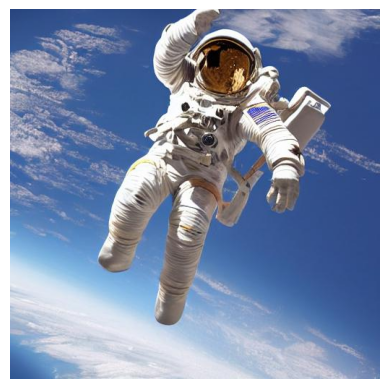

In [ ]:
img_path = '/home/astronaut.jpg'
img = load_img(img_path, 512, 512, return_tensor=True)
show_image(img)

In [ ]:
model = UNet2DConditionModel.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='unet').cuda()
tokenizer = AutoTokenizer.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='tokenizer')
text_encoder = CLIPTextModel.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='text_encoder')
vae = AutoencoderKL.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='vae').to('cuda')

In [ ]:
ddim_scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')

#### Step 1 - calculate masks

In the final implementation, need to be able to calculate a mask, or accept a mask tensor. I'm going to use DiffEdit here, but SAM works fine too. The advantage of DiffEdit is that it's usable just by changing the prompt, rather than faffing around with a point.

/home/libs/dragon_diffusion/dragon_diffusion/masks.py:126: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  shape = (1, model.in_channels, height // 8, width // 8)


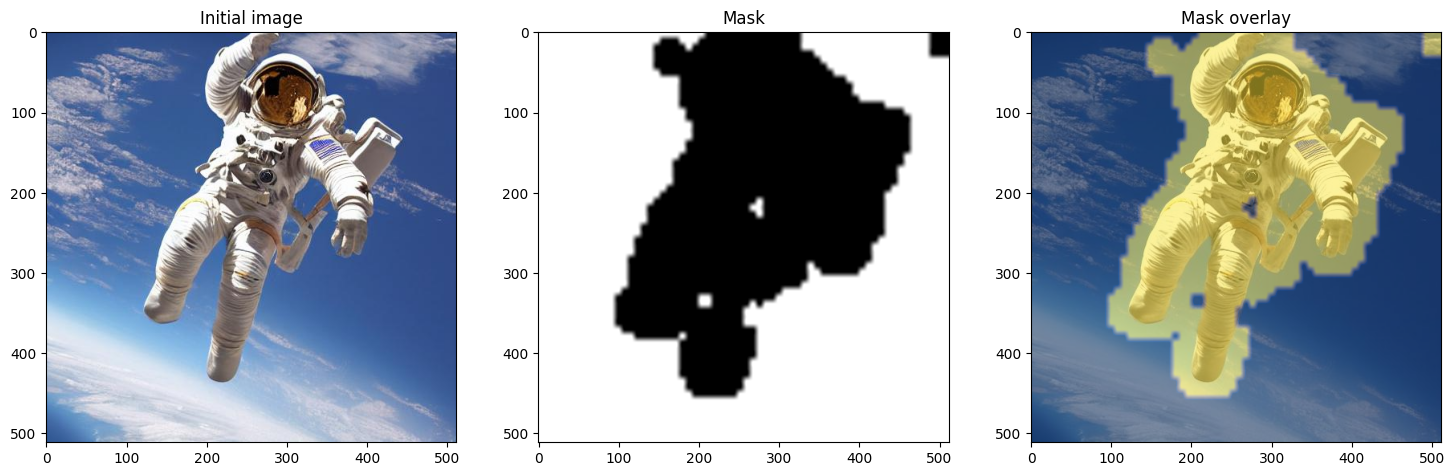

In [ ]:
edit_text = 'a goat floating above earth'
ref_text = 'an astronaut floating above earth'
mspace = ModelNamespace(model, scheduler, vae, tokenizer, text_encoder)
diffedit_mask(edit_text, ref_text, img_path, mspace, seed=42, erosion_it=8, dilation_it=14)

#### Step 2 - null text inversion

Handily, we've already done that. Note that in the final implementation, we'll only do null text optimisation in the event that it isn't a generated image — if we're generating the image as well, we'll just use the actual latent intermediates calculated across diffusion steps.

In [ ]:
prompt = 'an astronaut floating in space'
uncond_embeddings = get_embeddings("", text_encoder, tokenizer, concat_unconditional=False, device='cuda')
cond_embeddings = get_embeddings(prompt, text_encoder, tokenizer, concat_unconditional=False, device='cuda')

In [ ]:
height, width = 512, 512
latents = encode_img(img_path, height, width, vae) ## start from existing image
steps = 50
device = 'cuda'
ddim_scheduler.set_timesteps(steps)
all_latents = ddim_inversion(latents, cond_embeddings, ddim_scheduler, model)
print("DDIM inversion complete.")

DDIM inversion complete.


In [ ]:
embeddings = torch.cat([cond_embeddings, uncond_embeddings])
z_T, all_null_texts = null_text_inversion(model, ddim_scheduler, all_latents, embeddings, inner_steps=10)
print('Null text inversion complete')

Null text inversion complete


Now we have a trajectory of unconditional embeddings which we can use to reconstruct the original image. Using this, we can run a diffusion loop starting from a random point in latent space and get back the original image.

#### Step 3 - set up attention control

In [ ]:
# set up the custom attn processor and use to replace standard model processors
# note that this is only done for self-attention blocks in the decoder
storage = AttnStorage()
processor = partial(CustomAttnProcessor, storage)
attn_dict = get_attn_dict(processor, model, attention_type='attn1', location='decoder')
model.set_attn_processor(attn_dict)
print("Attention processors set.")

Attention processors set.


In [ ]:
# feature hooks
feat_layers = [1,2]
hooks = [Hook(model.up_blocks[i], get_features) for i in feat_layers]
print('Hooks created.')

Hooks created.


#### Step 4 - editing optimisation loop

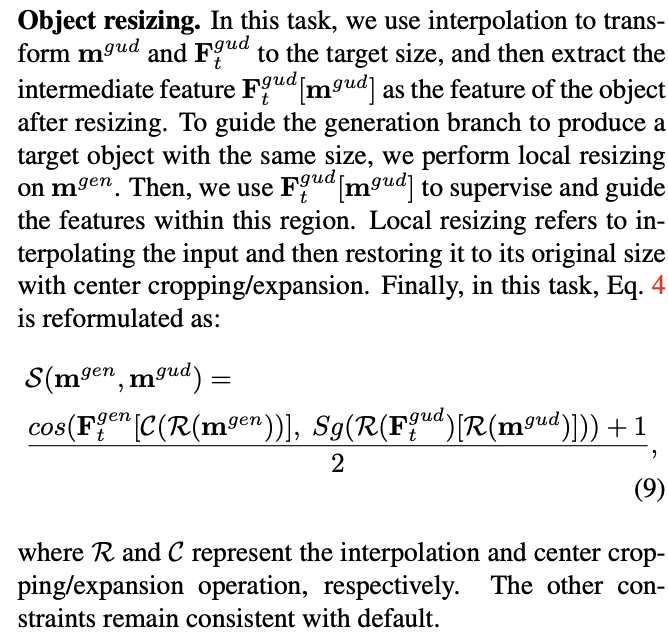

In [ ]:
def local_resize(image, target_size, binarise=False):
    
    if len(image.shape) == 3: image = image.unsqueeze(0)
    interpolated_image = F.interpolate(image, size=target_size, mode='bilinear', align_corners=False)
    original_size = image.shape[-1]
    if target_size > original_size:
        # Center crop
        crop_size = original_size
        cropped_image = interpolated_image[
            :,
            :,
            (target_size - crop_size) // 2: (target_size + crop_size) // 2,
            (target_size - crop_size) // 2: (target_size + crop_size) // 2
        ]
        if binarise: 
            cropped_image[cropped_image > 0] = 1
            cropped_image = cropped_image.int()
        return cropped_image
    else:
        # Center expand
        padding = (original_size - target_size) // 2
        expanded_image = F.pad(interpolated_image, (padding, padding, padding, padding), mode='constant', value=0)
        if binarise: 
            expanded_image[expanded_image > 0] = 1
            expanded_image = expanded_image.int()
        return expanded_image

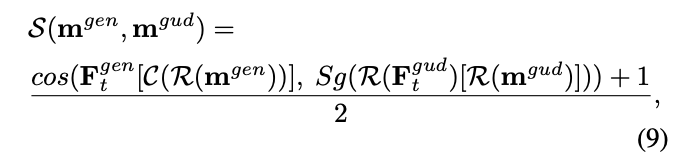

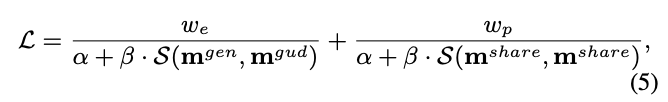

In [ ]:
# equation 5 and 9
def resize_loss(m_orig, m_edit, m_share_orig, m_share_edit, edit_weight=0.01, consistency_weight=0.05, alpha=1, beta=1):
    loss = []
    for mo, me, mso, mse in zip(m_orig, m_edit, m_share_orig, m_share_edit):
        cross_sim = (F.cosine_similarity(me, mo) + 1) / 2
        share_sim = (F.cosine_similarity(mso.float(), mse.float()) + 1) / 2
        t1 = edit_weight / (alpha + beta*cross_sim)
        t2 = consistency_weight / (alpha + beta*share_sim)
        loss.append((t1+t2).mean())
    return loss[0] + loss[1]

In [ ]:
def load_mask(mask_path, height, width, device='cpu'):
    mask = load_img(mask_path, height, width, return_tensor=True, device=device)
    mask[mask > 0] = 1
    return mask

In [ ]:
ddim_scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')
scheduler_2 = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')

In [ ]:
# all_null_texts.append(uncond_embeddings)

In [ ]:
steps = 50
ddim_scheduler.set_timesteps(steps)
scheduler_2.set_timesteps(steps)
device = 'cuda'
orig_latents, edit_latents = z_T.clone().detach().to(device), z_T.clone().detach()
edit_latents = nn.Parameter(edit_latents).detach().to(device)
guidance = 5
lr = 1e-2
eta = 5e5

mask_path = '/home/mask.jpg'
feat_1_mask = load_mask(mask_path, height//16, width//16)
feat_2_mask = load_mask(mask_path, height//8, width//8)
masks = (feat_1_mask.to(device), feat_2_mask.to(device))

for i, t in enumerate(progress_bar(ddim_scheduler.timesteps, leave=False, comment='editing image...')):
    
    t = t.long()
    
    ##### (1) Reconstruction path #####
    
    latent_model_input = ddim_scheduler.scale_model_input(orig_latents, t) ## orig_latents
    with torch.no_grad():
        uncond_embeddings_null = all_null_texts[i].to(device)
        
        # store attention for uncond pred
        prepare_attention(model, storage, set_store=True, set_inject=False, emb_type='uncond')
        uncond = model(latent_model_input, t, encoder_hidden_states=uncond_embeddings_null).sample

        # store attention for cond pred separately
        prepare_attention(model, storage, set_store=True, set_inject=False, emb_type='cond')
        cond = model(latent_model_input, t, encoder_hidden_states=cond_embeddings).sample
        
        # get features
        f_orig = tuple([h.feats for h in hooks])
    
    # prediction for reconstructed image, based on null text embeddings
    orig_noise_pred = uncond + guidance * (cond - uncond)
    orig_latents = ddim_scheduler.step(orig_noise_pred, t, orig_latents).prev_sample
    
    
    ##### (2) Editing path #####
    
    edit_latents.requires_grad_(True)
    edit_latents.retain_grad()
    
    latent_model_input = scheduler_2.scale_model_input(edit_latents, t) ## edit_latents
    
    # inject uncond attention
    prepare_attention(model, storage, set_store=False, set_inject=True, emb_type='uncond')
    uncond = model(latent_model_input, t, encoder_hidden_states=uncond_embeddings_null).sample
    
    # inject cond attention
    prepare_attention(model, storage, set_store=False, set_inject=True, emb_type='cond')
    cond = model(latent_model_input, t, encoder_hidden_states=cond_embeddings).sample
    
    # get features
    f_edit = tuple([h.feats for h in hooks])
    
    # classifier-free guidance
    edit_noise_pred = uncond + guidance * (cond - uncond)
    
    # resize the mask according to each feature size and 
    # isolate the masked area. Remember that there are *multiple*
    # feature layers being used, so this is a bit annoying
    masks_resize = [local_resize(m, m.shape[-1]*2, binarise=True) for m in masks]
    f_orig_resize = [local_resize(f, f.shape[-1]*2) for f in f_orig]
    m_orig = [m*f for m,f in zip(masks_resize, f_orig_resize)]
    m_share_orig = [~m for m in masks_resize]
    m_edit = [m*f for m,f in zip(masks_resize, f_edit)]
    m_share_edit = [~m for m in masks_resize]
    
    # do loss function
    loss = resize_loss(m_orig, m_edit, m_share_orig, m_share_edit)
    loss.backward()
    print("Mean: ", eta*edit_latents.grad.mean().item())
    edit_noise_pred += masks[1]*eta*edit_latents.grad
    edit_latents = scheduler_2.step(edit_noise_pred.detach(), t, edit_latents.detach()).prev_sample
    storage.flush()
    
orig_latents = 1 / 0.18215 * orig_latents
edit_latents = 1 / 0.18215 * edit_latents

with torch.no_grad(): 
    edit_img = decode_img(edit_latents, vae)
    orig_img = decode_img(orig_latents, vae)

Mean:  -0.051489905672497116
Mean:  -0.007874853658051961
Mean:  -0.003156603645138034
Mean:  -0.019882644863855603
Mean:  -0.013615295557656282
Mean:  -0.012643331714912165
Mean:  -0.006660340723385616
Mean:  -0.016742006891945493
Mean:  6.136957608759985e-05
Mean:  -0.011915575193199857
Mean:  -0.01057652010416632
Mean:  -0.009963233793541804
Mean:  -0.011165299795834471
Mean:  -0.00936931066064517
Mean:  -0.008629911896207432
Mean:  -0.00633114982662164
Mean:  -0.010016909968157961
Mean:  -0.00201833927349071
Mean:  -0.002119474373785124
Mean:  -0.0015345391624066451
Mean:  -0.0007244749800072725
Mean:  -0.0010283085494222632
Mean:  -0.001993779807918372
Mean:  -0.0005771092492778962
Mean:  -0.00043072304056757105
Mean:  -0.0007958114722761422
Mean:  -0.0012889991296560765
Mean:  -0.0014003462833755975
Mean:  -0.001033466978661579
Mean:  -0.0023225841250251733
Mean:  -0.0014463225062044671
Mean:  -0.0015155467991689875
Mean:  -0.0016322155849124442
Mean:  -0.0021773800540358934
Mean

In [ ]:
image = load_img(img_path, 512, 512)

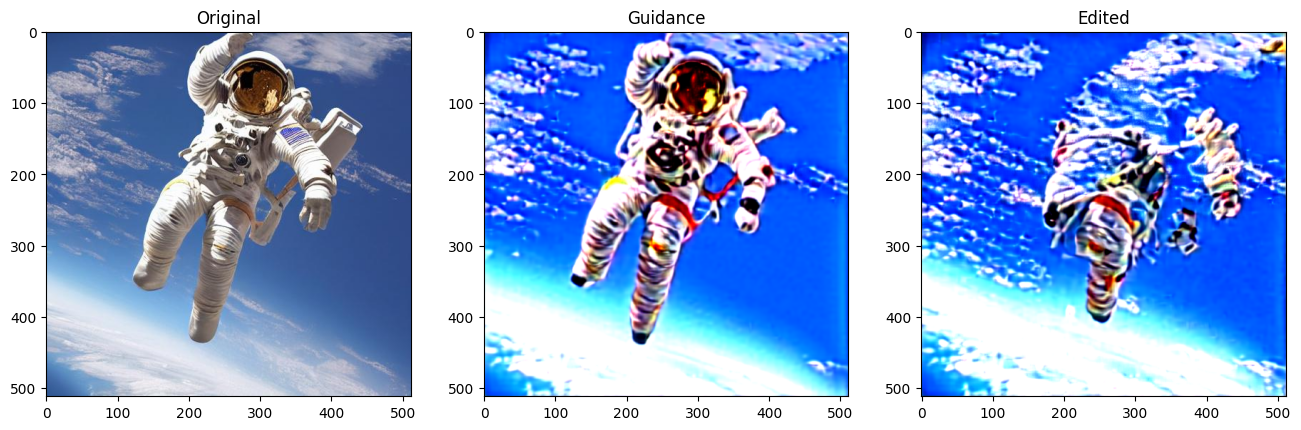

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(16,8))
for i, (img, title) in enumerate(zip([image, orig_img, edit_img], ["Original", "Guidance", "Edited"])):
    ax[i].imshow(img)
    ax[i].set_title(title)

Things to try:

1. ~Use the null text uncond embeddings for the edited image?~
2. ~Inject attention for the uncond prediction in the editing path?~
3. ~Separately inject attention from the uncond and cond strands?~
4. Am I including the gradients correctly? Perhaps I need to factor the mask into the grads. Surely grads in the share mask should be 0.

Dragon Diffusion class

1. Enable calculation of mask, or accept a custom mask.
2. Enable generation of image, or accept an image.
3. If generated image, store the intermediate latents.
4. If input image, perform null text inversion.